In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
# import plotly
# import plotly.express as px

In [4]:
# input image dimensions
img_rows, img_cols = 32, 32
img_chn = 1

In [5]:
# Load CIFAR-10 dataset-
(train_images, y_train), (test_images, y_test) = cifar10.load_data()
if img_chn == 1:
    train_images = train_images.mean(axis=3)                                                                                    
    test_images = test_images.mean(axis=3)                                                                                    

In [6]:
input_shape = (img_rows, img_cols, img_chn)

In [7]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

# Convert datasets to floating point types-
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize the training and testing datasets-
if img_chn == 1:
    train_images = train_images.reshape((train_images.shape[0], \
                                         img_rows, img_rows, img_chn)) / 255.
    test_images = test_images.reshape((test_images.shape[0], \
                                      img_rows, img_rows, img_chn)) / 255.
else:
    train_images = train_images/255.
    test_images = test_images/255.


print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {train_images.shape} & X_test.shape: {test_images.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 1) & X_test.shape: (10000, 32, 32, 1)


In [8]:
def batch_creation(X_data, batch_size):
    end = X_data.shape[0]-1
    start = 0
    batch_split_X = list()
    while start < end:
        img_slice = np.array(X_data[start:start+batch_size])
        batch_split_X.append(img_slice)
        start = start + batch_size
    return np.array(batch_split_X, dtype=object)
    
train_dataset = batch_creation(train_images, 32)
test_dataset = batch_creation(test_images, 32)
train_dataset.shape

(1563,)

In [9]:
load_outlier_detector = True

latent_dim = 1024
epochs = 20


# train_size = train_images.shape[0]
# batch_size = 32
# test_size = test_images.shape[0]


# train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
# train_dataset = train_dataset.shuffle(train_size)
# train_dataset = train_dataset.batch(batch_size)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_images)\
#             .shuffle(test_size).batch(batch_size)




In [10]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
              [
                  tf.keras.layers.InputLayer(input_shape),
                  tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation=tf.nn.relu),
                  tf.keras.layers.Conv2D(64, 3, strides=2,  padding='same', activation=tf.nn.relu),
                  tf.keras.layers.Conv2D(128, 3, strides=2,  padding='same', activation=tf.nn.relu),
                  tf.keras.layers.Flatten(),
                  # No activation
                  tf.keras.layers.Dense(latent_dim + latent_dim ),
              ]
        )
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*128, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 128)),
            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same',  activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same',  activation=tf.nn.relu),
            # No activation
            tf.keras.layers.Conv2DTranspose(img_chn, 3, strides=2, padding='same'),
#             No activation
#             tf.keras.layers.Conv2DTranspose(
#                 filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )
        
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    @tf.function
    def train_step(self, x, optimizer):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

In [12]:
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [13]:
model = CVAE(latent_dim)
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
Total params: 4,289,024
Trainable params: 4,289,024
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
________________________

In [14]:
def plot_latent_images(model, n, epoch, im_size=32, save=True, first_epoch=False, f_ep_count=0):
    pass
    
#     # Create image matrix 
#     image_width = im_size*n
#     image_height = image_width
#     image = np.zeros((image_height, image_width, img_chn))

#     # Create list of values which are evenly spaced wrt probability mass

#     norm = tfp.distributions.Normal(0, 1)
#     grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
#     grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    
#     # For each point on the grid in the latent space, decode and

# #     # copy the image into the image array
# #     for i, yi in enumerate(grid_x):
# #         for j, xi in enumerate(grid_y):
# #             z = np.array([[xi, yi]])
# #             x_decoded = model.sample(z)
# #             digit = tf.reshape(x_decoded[0], (im_size, im_size, img_chn))
# #             image[i * im_size: (i + 1) * im_size,
# #                   j * im_size: (j + 1) * im_size] = digit.numpy()
    

#     # Plot the image array
#     plt.figure(figsize=(10, 10))
#     plt.imshow(image, cmap='Greys_r')
#     plt.axis('Off')


#     # Potentially save, with different formatting if within first epoch
#     if save and first_epoch:
#         plt.savefig('tf_grid_at_epoch_{:04d}.{:04d}.png'.format(epoch, f_ep_count))
#     elif save:
#         plt.savefig('tf_grid_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()

In [15]:
import time
tf.config.run_functions_eagerly(False)
plot_latent_images(model, 10, epoch=0)


optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for idx, train_x in enumerate(train_dataset):
        model.train_step(train_x, optimizer)
        if epoch == 1 and idx % 75 == 0:
            plot_latent_images(model, 10, epoch=epoch, first_epoch=True, f_ep_count=idx)          
    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    if epoch != 1:
        plot_latent_images(model, 20, epoch=epoch)


Epoch: 1, Test set ELBO: 663.8363647460938, time elapse for current epoch: 11.243090391159058
Epoch: 2, Test set ELBO: 655.3274536132812, time elapse for current epoch: 7.195418834686279
Epoch: 3, Test set ELBO: 653.3447265625, time elapse for current epoch: 6.787143230438232
Epoch: 4, Test set ELBO: 652.3555908203125, time elapse for current epoch: 6.766752004623413
Epoch: 5, Test set ELBO: 652.126220703125, time elapse for current epoch: 7.201196908950806
Epoch: 6, Test set ELBO: 651.52392578125, time elapse for current epoch: 7.829582691192627
Epoch: 7, Test set ELBO: 650.8648681640625, time elapse for current epoch: 7.216124057769775
Epoch: 8, Test set ELBO: 650.1179809570312, time elapse for current epoch: 7.117692708969116
Epoch: 9, Test set ELBO: 649.0217895507812, time elapse for current epoch: 7.341246843338013
Epoch: 10, Test set ELBO: 647.7882690429688, time elapse for current epoch: 7.240871906280518
Epoch: 11, Test set ELBO: 646.582275390625, time elapse for current epoch:

In [16]:
mean, var = model.encode(test_images)

In [17]:
z = model.reparameterize(mean, var)

In [18]:
recon = model.decode(z)

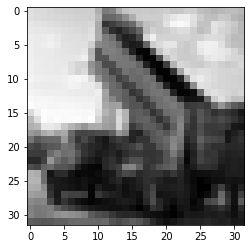

In [19]:
%matplotlib inline
i=50
plt.imshow(test_images[i],cmap='gray')


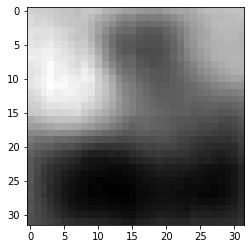

In [20]:
plt.imshow(recon[i],  cmap='gray')

In [21]:
from sklearn.manifold import TSNE

In [22]:
znp = z.numpy()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(znp)

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(z)

kmeans.cluster_centers_.shape

In [ ]:
kmeans

In [ ]:
sklearn.metrics.confusion_matrix(y_test, kmeans.labels_)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline